<a href="https://colab.research.google.com/github/danieldang1806/elearning_project/blob/main/US_Elearning_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# E-learning in U.S during pandemic

**Background:** An edtech company provides online courses in 3 main areas: 
- Career development
- High school and above
- Content creation

This analysis will focus on how e-learning shifted in U.S during pademic and this can be served as  intelligence for long-term business strategy of the company

**Overview**: <br>
1. **Target audience**: Business Development/ Marketing/ Academics teams
2. **Metric**: SES (SocioEconomic Status) score = Ethinicity score + Economic Status score + Expenditure score
3. **Flow of analysis**:
- EDA on components of SES score
- Segmentation by 3 main product functions by applying KMeans
- Conclusions and Recommendations

## Data preparation

### Import datasets

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

In [ ]:
sns.set_theme(style='whitegrid')

Import `districts_info` dataset

In [ ]:
# Import districts_info csv
districts = pd.read_csv('/content/drive/MyDrive/Final Project/districts_info.csv')

In [ ]:
# Drop na values
districts = districts[districts.state.notna()].reset_index(drop=True)

In [ ]:
districts.head()

,district_id,state,locale,pct_black/hispanic,pct_free/reduced,county_connections_ratio,pp_total_raw
0,8815,Illinois,Suburb,"[0, 0.2[","[0, 0.2[","[0.18, 1[","[14000, 16000["
1,4921,Utah,Suburb,"[0, 0.2[","[0.2, 0.4[","[0.18, 1[","[6000, 8000["
2,5987,Wisconsin,Suburb,"[0, 0.2[","[0, 0.2[","[0.18, 1[","[10000, 12000["
3,3710,Utah,Suburb,"[0, 0.2[","[0.4, 0.6[","[0.18, 1[","[6000, 8000["
4,7177,North Carolina,Suburb,"[0.2, 0.4[","[0.2, 0.4[","[0.18, 1[","[8000, 10000["


In [ ]:
districts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176 entries, 0 to 175
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   district_id               176 non-null    int64 
 1   state                     176 non-null    object
 2   locale                    176 non-null    object
 3   pct_black/hispanic        176 non-null    object
 4   pct_free/reduced          148 non-null    object
 5   county_connections_ratio  162 non-null    object
 6   pp_total_raw              118 non-null    object
dtypes: int64(1), object(6)
memory usage: 9.8+ KB


Import `engagement` dataset of all districts

In [ ]:
# Import engagement csv
engagement = pd.read_csv('/content/drive/MyDrive/Final Project/engagement.csv')

In [ ]:
engagement.head()

,Unnamed: 0,time,lp_id,pct_access,engagement_index,district_id
0,0,2020-01-01,15254,0.21,2.07,3710
1,1,2020-01-01,52755,0.21,4.13,3710
2,2,2020-01-01,32213,0.62,12.40,3710
3,3,2020-01-01,16633,0.21,2.07,3710
4,4,2020-01-01,94324,0.21,6.20,3710


In [ ]:
engagement.dropna(subset=['lp_id'], inplace=True)

In [ ]:
engagement['lp_id'] = engagement['lp_id'].astype(np.int64)

In [ ]:
engagement['time'] = pd.to_datetime(engagement['time'])

In [ ]:
engagement.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14913580 entries, 0 to 14913579
Data columns (total 6 columns):
 #   Column            Dtype         
---  ------            -----         
 0   Unnamed: 0        int64         
 1   time              datetime64[ns]
 2   lp_id             int64         
 3   pct_access        float64       
 4   engagement_index  float64       
 5   district_id       int64         
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 796.5 MB


Import `products_info` dataset

In [ ]:
# Import products_info csv
products = pd.read_csv('/content/drive/MyDrive/Final Project/products_info.csv')

In [ ]:
products = products.rename(columns={'LP ID': 'lp_id', 
                                    'Product Name': 'name', 
                                    'Provider/Company Name': 'provider', 
                                    'Sector(s)': 'sector', 
                                    'Primary Essential Function': 'function'})

In [ ]:
products.head()

,lp_id,URL,name,provider,sector,function
0,13117,https://www.splashmath.com,SplashLearn,StudyPad Inc.,PreK-12,LC - Digital Learning Platforms
1,66933,https://abcmouse.com,ABCmouse.com,"Age of Learning, Inc",PreK-12,LC - Digital Learning Platforms
2,50479,https://www.abcya.com,ABCya!,"ABCya.com, LLC",PreK-12,"LC - Sites, Resources & Reference - Games & Si..."
3,92993,http://www.aleks.com/,ALEKS,McGraw-Hill PreK-12,PreK-12; Higher Ed,LC - Digital Learning Platforms
4,73104,https://www.achieve3000.com/,Achieve3000,Achieve3000,PreK-12,LC - Digital Learning Platforms


In [ ]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 372 entries, 0 to 371
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   lp_id     372 non-null    int64 
 1   URL       372 non-null    object
 2   name      372 non-null    object
 3   provider  371 non-null    object
 4   sector    352 non-null    object
 5   function  352 non-null    object
dtypes: int64(1), object(5)
memory usage: 17.6+ KB


### Merge all to one dataset only

In [ ]:
df = pd.merge(engagement, districts, how='left', on='district_id')

In [ ]:
df = pd.merge(df, products, how='inner', on='lp_id')

In [ ]:
# Drop all na values in engagement_index
df = df[~df['engagement_index'].isna()]

In [ ]:
df = df.iloc[:, 1:]

In [ ]:
df.head()

,time,lp_id,pct_access,engagement_index,district_id,state,locale,pct_black/hispanic,pct_free/reduced,county_connections_ratio,pp_total_raw,URL,name,provider,sector,function
0,2020-01-01,15254,0.21,2.07,3710,Utah,Suburb,"[0, 0.2[","[0.4, 0.6[","[0.18, 1[","[6000, 8000[",http://appinventor.mit.edu/explore/,MIT App Inventor,Massachusetts Institute of Technology,PreK-12; Higher Ed; Corporate,LC - Content Creation & Curation
1,2020-01-04,15254,0.41,20.66,3710,Utah,Suburb,"[0, 0.2[","[0.4, 0.6[","[0.18, 1[","[6000, 8000[",http://appinventor.mit.edu/explore/,MIT App Inventor,Massachusetts Institute of Technology,PreK-12; Higher Ed; Corporate,LC - Content Creation & Curation
2,2020-01-05,15254,0.21,37.19,3710,Utah,Suburb,"[0, 0.2[","[0.4, 0.6[","[0.18, 1[","[6000, 8000[",http://appinventor.mit.edu/explore/,MIT App Inventor,Massachusetts Institute of Technology,PreK-12; Higher Ed; Corporate,LC - Content Creation & Curation
3,2020-01-06,15254,0.21,6.19,3710,Utah,Suburb,"[0, 0.2[","[0.4, 0.6[","[0.18, 1[","[6000, 8000[",http://appinventor.mit.edu/explore/,MIT App Inventor,Massachusetts Institute of Technology,PreK-12; Higher Ed; Corporate,LC - Content Creation & Curation
4,2020-01-07,15254,0.21,134.02,3710,Utah,Suburb,"[0, 0.2[","[0.4, 0.6[","[0.18, 1[","[6000, 8000[",http://appinventor.mit.edu/explore/,MIT App Inventor,Massachusetts Institute of Technology,PreK-12; Higher Ed; Corporate,LC - Content Creation & Curation


## EDA

### Overview

First of all, we would like to examine the distribution of data based on 3 variables: Ethnicity, Economic status and Expenditure of the government

In [ ]:
df = df.dropna(subset=['engagement_index', 'pct_black/hispanic', 'pct_free/reduced', 'pp_total_raw'])

In [ ]:
print(f'The dataset contains: {df["state"].nunique()} states and {df["district_id"].nunique()} districts')

The dataset contains: 11 states and 64 districts


In [ ]:
ov_ethnicity = df.groupby('pct_black/hispanic')['district_id'].nunique().reset_index()
ov_ethnicity

,pct_black/hispanic,district_id
0,"[0, 0.2[",41
1,"[0.2, 0.4[",11
2,"[0.4, 0.6[",7
3,"[0.6, 0.8[",4
4,"[0.8, 1[",1


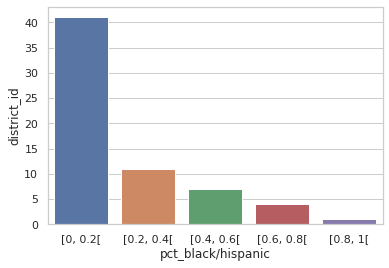

In [ ]:
sns.barplot(data=ov_ethnicity, 
            x='pct_black/hispanic', 
            y='district_id')

As there is only one district in the group of districts with 80-100% Black/Hispanic, we will eliminate it as only one district cannot be representative for the whole group. 

In [ ]:
df = df[df['pct_black/hispanic'] != '[0.8, 1[']

In [ ]:
ov_disadvantage = df.groupby('pct_free/reduced')['district_id'].nunique().reset_index()
ov_disadvantage

,pct_free/reduced,district_id
0,"[0, 0.2[",14
1,"[0.2, 0.4[",21
2,"[0.4, 0.6[",20
3,"[0.6, 0.8[",8


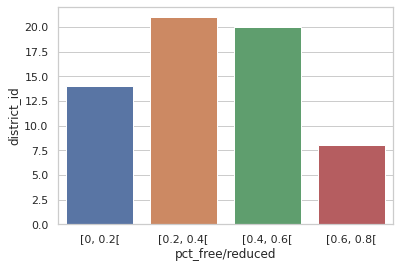

In [ ]:
sns.barplot(data=ov_disadvantage,
            x='pct_free/reduced', 
            y='district_id')

In [ ]:
ov_expenditure_before = df.groupby('pp_total_raw')['district_id'].nunique().reset_index()
ov_expenditure_before

,pp_total_raw,district_id
0,"[10000, 12000[",12
1,"[12000, 14000[",9
2,"[14000, 16000[",4
3,"[16000, 18000[",2
4,"[18000, 20000[",2
5,"[22000, 24000[",1
6,"[4000, 6000[",2
7,"[6000, 8000[",10
8,"[8000, 10000[",21


As there is only one district in the group of 22k-24k range in government spending, we will drop it out of the analysis. 

In [ ]:
df = df[df['pp_total_raw'] != '[22000, 24000[']

In order to simplify the categories in this group, we will combine into 4 categories only:

In [ ]:
exp_simplify = {'[4000, 6000[': '4k-8k', 
                '[6000, 8000[': '4k-8k',
                '[8000, 10000[': '8k-12k',
                '[10000, 12000[': '8k-12k',
                '[12000, 14000[': '12k-16k',
                '[14000, 16000[': '12k-16k',
                '[16000, 18000[': '16k-20k',
                '[18000, 20000[': '16k-20k'}

In [ ]:
df['exp_group'] = df['pp_total_raw'].map(exp_simplify)

In [ ]:
ov_expenditure = df.groupby('exp_group')['district_id'].nunique().reset_index()
ov_expenditure

,exp_group,district_id
0,12k-16k,13
1,16k-20k,4
2,4k-8k,12
3,8k-12k,33


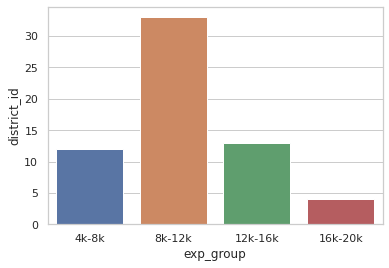

In [ ]:
sns.barplot(data=ov_expenditure, 
            x='exp_group',
            y='district_id', 
            order=['4k-8k', '8k-12k', '12k-16k', '16k-20k'])

### Insights

Set up functions to be used for computation accross the analysis

The below function will help outputing the result of t-test, p-value as well as the difference rate between outbreak and pre-outbreak periods

In [ ]:
def calculation_test_periods(df, category, value):

  tmp = df.groupby([category, 'time'])['engagement_index'].mean().reset_index()


  pre = tmp[tmp['time'] <= '2020-04-28']

  pre_verylow = pre[pre[category] == value[0]]
  pre_low = pre[pre[category] == value[1]]
  pre_medium = pre[pre[category] == value[2]]
  pre_high = pre[pre[category] == value[3]]


  out = tmp[(tmp['time'] >= '2020-09-01') & (tmp['time'] <= '2020-12-18')]

  out_verylow = out[out[category] == value[0]]
  out_low = out[out[category] == value[1]]
  out_medium = out[out[category] == value[2]]
  out_high = out[out[category] == value[3]]


  t_pre_verylow = pre_verylow.loc[:, 'engagement_index'].to_numpy()
  t_out_verylow = out_verylow.loc[:, 'engagement_index'].to_numpy()
  result_verylow = st.ttest_ind(a = t_pre_verylow, b = t_out_verylow, equal_var = True)

  t_pre_low = pre_low.loc[:, 'engagement_index'].to_numpy()
  t_out_low = out_low.loc[:, 'engagement_index'].to_numpy()
  result_low = st.ttest_ind(a = t_pre_low, b = t_out_low, equal_var = True)

  t_pre_medium = pre_medium.loc[:, 'engagement_index'].to_numpy()
  t_out_medium = out_medium.loc[:, 'engagement_index'].to_numpy()
  result_medium = st.ttest_ind(a = t_pre_medium, b = t_out_medium, equal_var = True)

  t_pre_high = pre_high.loc[:, 'engagement_index'].to_numpy()
  t_out_high = out_high.loc[:, 'engagement_index'].to_numpy()
  result_high = st.ttest_ind(a = t_pre_high, b = t_out_high, equal_var = True)

  alpha = 0.05 

  result_all = pd.DataFrame({'t': [result_verylow[0], 
                                   result_low[0],
                                   result_medium[0],
                                   result_high[0]], 
                             'p': ["{:.6f}".format(result_verylow[1]) + "*" if result_verylow[1]<=alpha else result_verylow[1],
                                   "{:.6f}".format(result_low[1]) + "*" if result_low[1]<=alpha else result_low[1],
                                   "{:.6f}".format(result_medium[1]) + "*" if result_medium[1]<=alpha else result_medium[1],
                                   "{:.6f}".format(result_high[1]) + "*" if result_high[1]<=alpha else result_high[1]]})
  


  tmp_pre = pre.groupby(category)['engagement_index'].mean().reset_index()
  tmp_out = out.groupby(category)['engagement_index'].mean().reset_index()
  tmp_all = pd.merge(tmp_pre, tmp_out, how='inner', on=category)
  tmp_all = tmp_all.rename(columns={'engagement_index_x': 'pre_outbreak', 
                                    'engagement_index_y': 'outbreak'})
  

  final = pd.concat([tmp_all, result_all], axis=1)

  final['diff'] = (final['outbreak'] / final['pre_outbreak']) - 1
  return final

The idea of below function is to calculate the percent of days with greater engagement index divided by the 3 main factors of this analysis.

In [ ]:
def calculation_percent(df, category, value):

  p_t = pd.pivot(data = df.groupby([category, 'time'])['engagement_index'].mean().reset_index(), 
                 index = 'time', 
                 columns = category, 
                 values = ['engagement_index'])

  verylow = 100*sum(
      (p_t[('engagement_index', value[0])] > p_t[('engagement_index', value[1])]) &
      (p_t[('engagement_index', value[0])] > p_t[('engagement_index', value[2])]) &
      (p_t[('engagement_index', value[0])] > p_t[('engagement_index', value[3])])) / p_t.shape[0]

  low = 100*sum(
      (p_t[('engagement_index', value[1])] > p_t[('engagement_index', value[0])]) &
      (p_t[('engagement_index', value[1])] > p_t[('engagement_index', value[2])]) &
      (p_t[('engagement_index', value[1])] > p_t[('engagement_index', value[3])])) / p_t.shape[0]

  medium = 100*sum(
      (p_t[('engagement_index', value[2])] > p_t[('engagement_index', value[1])]) &
      (p_t[('engagement_index', value[2])] > p_t[('engagement_index', value[0])]) &
      (p_t[('engagement_index', value[2])] > p_t[('engagement_index', value[3])])) / p_t.shape[0]
 
  high = 100*sum(
      (p_t[('engagement_index', value[3])] > p_t[('engagement_index', value[1])]) &
      (p_t[('engagement_index', value[3])] > p_t[('engagement_index', value[2])]) &
      (p_t[('engagement_index', value[3])] > p_t[('engagement_index', value[0])])) / p_t.shape[0]


  df_tmp = pd.DataFrame({category: value, 
                        'percent_day_greater': [verylow, low, medium, high]})

  df_tmp['score'] = df_tmp['percent_day_greater'].rank()
  
  return df_tmp

#### Ethinicity

**Changes over time in Ethnicity**

In [ ]:
ethnicity = df.groupby(['pct_black/hispanic', 'time'])['engagement_index'].mean().reset_index()

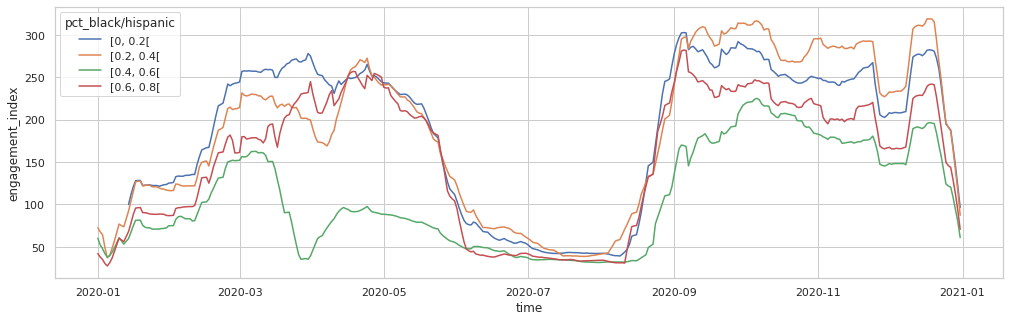

In [ ]:
plt.figure(figsize=(17,5))

sns.lineplot(x=ethnicity['time'], 
             y=ethnicity['engagement_index'].rolling(14).mean(), 
             hue=ethnicity['pct_black/hispanic'])

In [ ]:
eth_change = pd.DataFrame({'time': ethnicity['time'], 
              'engagement_index': ethnicity['engagement_index'].rolling(14).mean(),
              'pct_black/hispanic': ethnicity['pct_black/hispanic']})

eth_change.head()

,time,engagement_index,pct_black/hispanic
0,2020-01-01,NaN,"[0, 0.2["
1,2020-01-02,NaN,"[0, 0.2["
2,2020-01-03,NaN,"[0, 0.2["
3,2020-01-04,NaN,"[0, 0.2["
4,2020-01-05,NaN,"[0, 0.2["


Except summer break, we can see a clear difference in trend that between 2 school-year period (2019/2020 and 2020/2021), most of the time, students in districts with below 40% Black/Hispanic have higher engagement than the others remained. 

**Statistical summary in trending between pre-outbreak and outbreak periods**

In this section, we will process the statistical test result in order to prove that there is a significant difference betweens 2 periods: pre-outbreak and outbreak

In [ ]:
eth_value = ethnicity['pct_black/hispanic'].unique()
eth_value

array(['[0, 0.2[', '[0.2, 0.4[', '[0.4, 0.6[', '[0.6, 0.8['], dtype=object)

In [ ]:
eth_periods = calculation_test_periods(df, 'pct_black/hispanic', eth_value)
eth_periods

,pct_black/hispanic,pre_outbreak,outbreak,t,p,diff
0,"[0, 0.2[",205.388166,261.287240,-3.314478,0.001069*,0.272163
1,"[0.2, 0.4[",182.107644,292.673666,-6.818276,0.000000*,0.607147
2,"[0.4, 0.6[",94.012547,188.186212,-8.631088,0.000000*,1.001714
3,"[0.6, 0.8[",167.246859,221.806413,-3.415412,0.000755*,0.326222


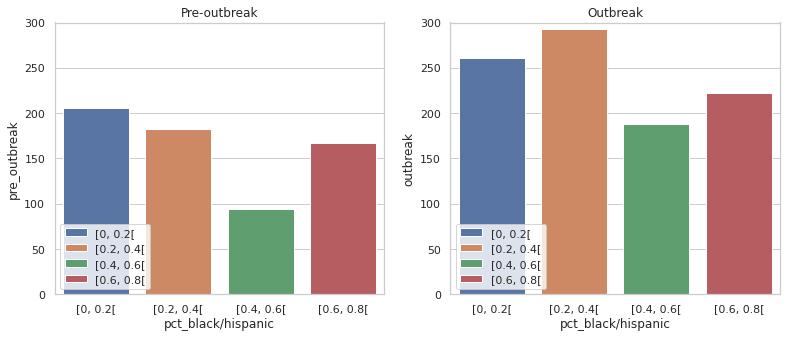

In [ ]:
plt.figure(figsize=(13,5))

plt.subplot(121)
sns.barplot(data=eth_periods, x='pct_black/hispanic', y='pre_outbreak', hue='pct_black/hispanic', dodge=False)
plt.ylim(0, 300)
plt.title('Pre-outbreak')
plt.legend(loc='lower left')

plt.subplot(122)
sns.barplot(data=eth_periods, x='pct_black/hispanic', y='outbreak', hue='pct_black/hispanic', dodge=False)
plt.ylim(0,300)
plt.title('Outbreak')
plt.legend(loc='lower left')

In [ ]:
eth_periods[['pct_black/hispanic', 't', 'p']]

,pct_black/hispanic,t,p
0,"[0, 0.2[",-3.314478,0.001069*
1,"[0.2, 0.4[",-6.818276,0.000000*
2,"[0.4, 0.6[",-8.631088,0.000000*
3,"[0.6, 0.8[",-3.415412,0.000755*


In [ ]:
eth_compare = eth_periods.melt(id_vars=['pct_black/hispanic'], 
                 value_vars=['pre_outbreak', 'outbreak', 'diff'], 
                 var_name='category', 
                 value_name='value')
eth_compare

,pct_black/hispanic,category,value
0,"[0, 0.2[",pre_outbreak,205.388166
1,"[0.2, 0.4[",pre_outbreak,182.107644
2,"[0.4, 0.6[",pre_outbreak,94.012547
3,"[0.6, 0.8[",pre_outbreak,167.246859
4,"[0, 0.2[",outbreak,261.287240
5,"[0.2, 0.4[",outbreak,292.673666
6,"[0.4, 0.6[",outbreak,188.186212
7,"[0.6, 0.8[",outbreak,221.806413
8,"[0, 0.2[",diff,0.272163
9,"[0.2, 0.4[",diff,0.607147


Based on the above statistical table, with t-value are far from 0 and p-value is less than the alpha level (.05), we can reject the null hypothesis that there is no difference between means. <br>

The statistical summary gives us a clearer picture of trend in 2 periods between groups. The point is districts with a low rate of students color started with a highest engagement index of all groups but left behind later on. Other groups performed better during outbreak period, with highest engagement rate belongs to 20-40% Black/Hispanic while the highest growth calls the name of 40-60% Black/Hispanic (doubled).

**Percent of Days with greater engagement**



In [ ]:
eth_percent = calculation_percent(df, 'pct_black/hispanic', eth_value)
eth_percent

,pct_black/hispanic,percent_day_greater,score
0,"[0, 0.2[",34.426230,3.0
1,"[0.2, 0.4[",56.284153,4.0
2,"[0.4, 0.6[",0.273224,1.0
3,"[0.6, 0.8[",9.016393,2.0


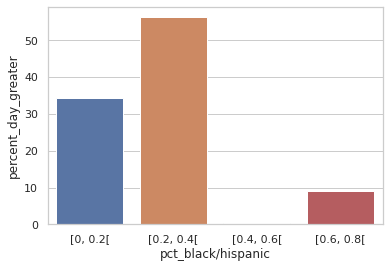

In [ ]:
sns.barplot(data=eth_percent, 
            x='pct_black/hispanic', 
            y='percent_day_greater')

In general, regarding the performance of 4 groups during 2020, students in districts with 20-40% Black/Hispanic have the highest percent of days with greater engagement than the other 3 while students in districts with above 40% of Black/Hispanic population have lowest engagement index. As we can conclude, districts with students of color, on average, engaged e-learning with much lower rate than districts less multiracial.

#### Economic status

**Changes over time**

In [ ]:
disadvantage = df.groupby(['pct_free/reduced', 'time'])['engagement_index'].mean().reset_index()

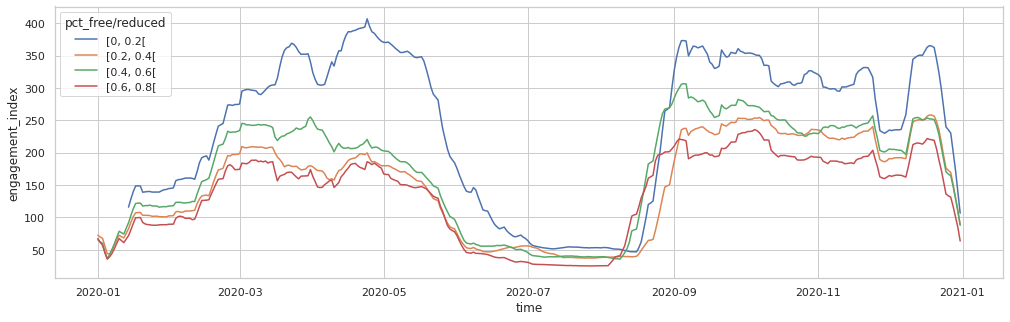

In [ ]:
plt.figure(figsize=(17,5))

sns.lineplot(x=disadvantage['time'], 
             y=disadvantage['engagement_index'].rolling(14).mean(), 
             hue=disadvantage['pct_free/reduced'])

In [ ]:
dis_change = pd.DataFrame({'time': disadvantage['time'], 
              'engagement_index': disadvantage['engagement_index'].rolling(14).mean(),
              'pct_free/reduced': disadvantage['pct_free/reduced']})

dis_change.head()

,time,engagement_index,pct_free/reduced
0,2020-01-01,NaN,"[0, 0.2["
1,2020-01-02,NaN,"[0, 0.2["
2,2020-01-03,NaN,"[0, 0.2["
3,2020-01-04,NaN,"[0, 0.2["
4,2020-01-05,NaN,"[0, 0.2["


Districts with a low rate of students eligible for Free/Reduced Lunch tend to have higher engagement index most of the time.

**Statistical summary in trending between pre-outbreak and outbreak periods**

In [ ]:
dis_value = disadvantage['pct_free/reduced'].unique()
dis_value

array(['[0, 0.2[', '[0.2, 0.4[', '[0.4, 0.6[', '[0.6, 0.8['], dtype=object)

In [ ]:
dis_periods = calculation_test_periods(df, 'pct_free/reduced', dis_value)
dis_periods

,pct_free/reduced,pre_outbreak,outbreak,t,p,diff
0,"[0, 0.2[",263.513128,325.811043,-2.721795,0.006999*,0.236413
1,"[0.2, 0.4[",156.033548,235.231397,-5.878315,0.000000*,0.507569
2,"[0.4, 0.6[",185.582651,250.769590,-4.214685,0.000036*,0.351256
3,"[0.6, 0.8[",142.205427,200.683466,-4.482261,0.000012*,0.411222


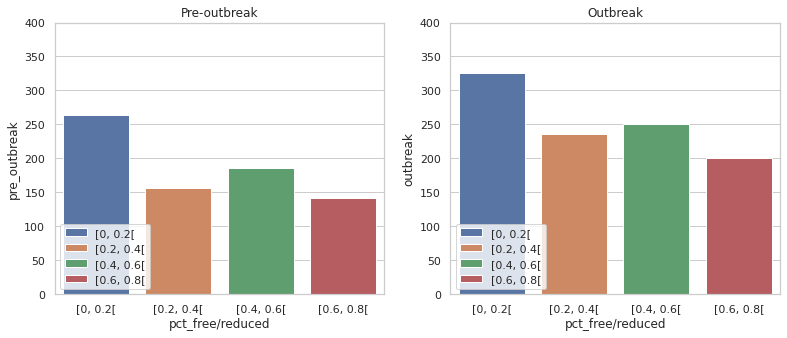

In [ ]:
plt.figure(figsize=(13,5))

plt.subplot(121)
sns.barplot(data=dis_periods, x='pct_free/reduced', y='pre_outbreak', hue='pct_free/reduced', dodge=False)
plt.ylim(0, 400)
plt.title('Pre-outbreak')
plt.legend(loc='lower left')

plt.subplot(122)
sns.barplot(data=dis_periods, x='pct_free/reduced', y='outbreak', hue='pct_free/reduced', dodge=False)
plt.ylim(0,400)
plt.title('Outbreak')
plt.legend(loc='lower left')

In [ ]:
dis_periods[['pct_free/reduced', 't', 'p']]

,pct_free/reduced,t,p
0,"[0, 0.2[",-2.721795,0.006999*
1,"[0.2, 0.4[",-5.878315,0.000000*
2,"[0.4, 0.6[",-4.214685,0.000036*
3,"[0.6, 0.8[",-4.482261,0.000012*


In [ ]:
dis_compare = dis_periods.melt(id_vars=['pct_free/reduced'], 
                 value_vars=['pre_outbreak', 'outbreak', 'diff'], 
                 var_name='category', 
                 value_name='value')
dis_compare

,pct_free/reduced,category,value
0,"[0, 0.2[",pre_outbreak,263.513128
1,"[0.2, 0.4[",pre_outbreak,156.033548
2,"[0.4, 0.6[",pre_outbreak,185.582651
3,"[0.6, 0.8[",pre_outbreak,142.205427
4,"[0, 0.2[",outbreak,325.811043
5,"[0.2, 0.4[",outbreak,235.231397
6,"[0.4, 0.6[",outbreak,250.769590
7,"[0.6, 0.8[",outbreak,200.683466
8,"[0, 0.2[",diff,0.236413
9,"[0.2, 0.4[",diff,0.507569


Based on the above statistical summary, there is difference between 2 means in 2 periods and this pattern of change if significant. 

**Percent of Days with greater engagement**



In [ ]:
dis_percent = calculation_percent(df, 'pct_free/reduced', dis_value)
dis_percent

,pct_free/reduced,percent_day_greater,score
0,"[0, 0.2[",86.338798,4.0
1,"[0.2, 0.4[",1.912568,1.0
2,"[0.4, 0.6[",9.562842,3.0
3,"[0.6, 0.8[",2.185792,2.0


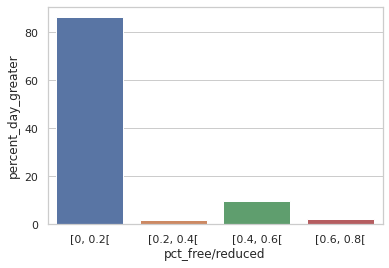

In [ ]:
sns.barplot(data=dis_percent, 
            x='pct_free/reduced', 
            y='percent_day_greater')

Based on the above chart, we can see clearly that students born in favorable economic conditions are associated with highest engagement index while the remained groups have much lower engagement index with just below 10%.

#### Expenditure

**Changes over time**

In [ ]:
expenditure = df.groupby(['exp_group', 'time'])['engagement_index'].mean().reset_index()

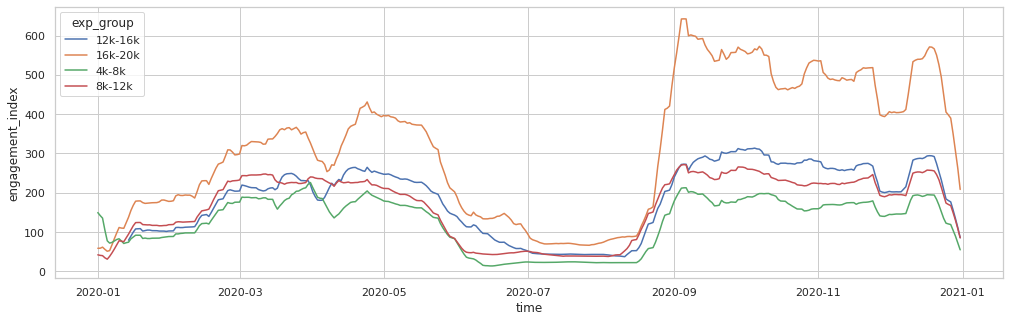

In [ ]:
plt.figure(figsize=(17,5))

sns.lineplot(x=expenditure['time'], 
             y=expenditure['engagement_index'].rolling(14).mean(), 
             hue=expenditure['exp_group'])

In [ ]:
exp_change = pd.DataFrame({'time': expenditure['time'], 
              'engagement_index': expenditure['engagement_index'].rolling(14).mean(),
              'exp_group': expenditure['exp_group']})

exp_change.head()

,time,engagement_index,exp_group
0,2020-01-01,NaN,12k-16k
1,2020-01-02,NaN,12k-16k
2,2020-01-03,NaN,12k-16k
3,2020-01-04,NaN,12k-16k
4,2020-01-05,NaN,12k-16k


Highest expenditure districts' students tend to have from high to very high engagement index over the time. 

**Statistical summary in trending between pre-outbreak and outbreak periods**

In [ ]:
exp_value = ['4k-8k', '8k-12k', '12k-16k', '16k-20k']
exp_value

['4k-8k', '8k-12k', '12k-16k', '16k-20k']

In [ ]:
exp_periods = calculation_test_periods(df, 'exp_group', exp_value)
exp_periods

,exp_group,pre_outbreak,outbreak,t,p,diff
0,12k-16k,180.435069,277.584893,-2.296456,0.022566*,0.538420
1,16k-20k,279.375704,521.018394,-3.296157,0.001138*,0.864938
2,4k-8k,147.842867,177.740543,-5.675777,0.000000*,0.202226
3,8k-12k,187.956780,237.665013,-8.285583,0.000000*,0.264466


In [ ]:
from pandas.api.types import CategoricalDtype

In [ ]:
exp_order = CategoricalDtype(['4k-8k', '8k-12k', '12k-16k', '16k-20k'], ordered=True)

In [ ]:
exp_periods['exp_group'] = exp_periods['exp_group'].astype(exp_order)
exp_periods = exp_periods.sort_values('exp_group')
exp_periods

,exp_group,pre_outbreak,outbreak,t,p,diff
2,4k-8k,147.842867,177.740543,-5.675777,0.000000*,0.202226
3,8k-12k,187.956780,237.665013,-8.285583,0.000000*,0.264466
0,12k-16k,180.435069,277.584893,-2.296456,0.022566*,0.538420
1,16k-20k,279.375704,521.018394,-3.296157,0.001138*,0.864938


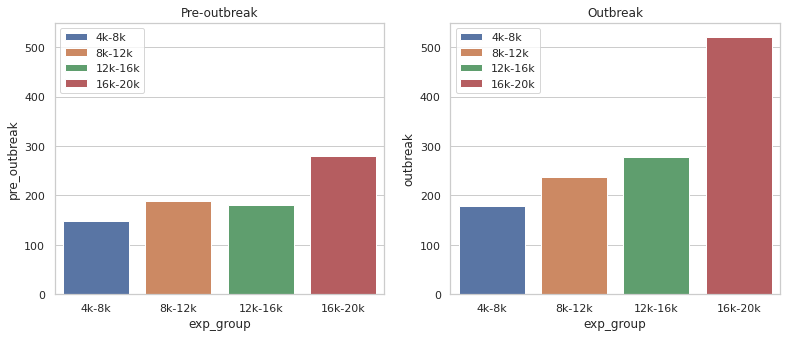

In [ ]:
plt.figure(figsize=(13,5))

plt.subplot(121)
sns.barplot(data=exp_periods, x='exp_group', y='pre_outbreak', hue='exp_group', dodge=False)
plt.ylim(0, 550)
plt.title('Pre-outbreak')
plt.legend(loc='upper left')

plt.subplot(122)
sns.barplot(data=exp_periods, x='exp_group', y='outbreak', hue='exp_group', dodge=False)
plt.ylim(0,550)
plt.title('Outbreak')
plt.legend(loc='upper left')

In [ ]:
exp_periods[['exp_group', 't', 'p']]

,exp_group,t,p
2,4k-8k,-5.675777,0.000000*
3,8k-12k,-8.285583,0.000000*
0,12k-16k,-2.296456,0.022566*
1,16k-20k,-3.296157,0.001138*


In [ ]:
exp_compare = exp_periods.melt(id_vars=['exp_group'], 
                 value_vars=['pre_outbreak', 'outbreak', 'diff'], 
                 var_name='category', 
                 value_name='value')
exp_compare

,exp_group,category,value
0,4k-8k,pre_outbreak,147.842867
1,8k-12k,pre_outbreak,187.956780
2,12k-16k,pre_outbreak,180.435069
3,16k-20k,pre_outbreak,279.375704
4,4k-8k,outbreak,177.740543
5,8k-12k,outbreak,237.665013
6,12k-16k,outbreak,277.584893
7,16k-20k,outbreak,521.018394
8,4k-8k,diff,0.202226
9,8k-12k,diff,0.264466


The statistical summary table clearly shows that there is difference between 2 means in 2 periods. This pattern of change is significant.

**Percent of Days with greater engagement**



In [ ]:
exp_percent = calculation_percent(df, 'exp_group', exp_value)
exp_percent

,exp_group,percent_day_greater,score
0,4k-8k,0.273224,1.0
1,8k-12k,3.005464,3.0
2,12k-16k,1.912568,2.0
3,16k-20k,94.808743,4.0


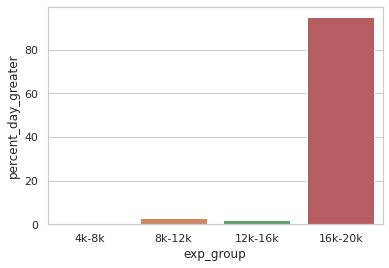

In [ ]:
sns.barplot(data=exp_percent, 
            x='exp_group', 
            y='percent_day_greater')

Based on the above chart, we can see clearly that students in highest expenditure districs are associated with highest engagement index while the remained groups have very low percentage of days with engagement index.

#### Correlation between 3E and Engagement rate

In [ ]:
correlation = df.groupby(['district_id', 'pct_black/hispanic', 'pct_free/reduced', 'exp_group'])['engagement_index'].mean().reset_index()
correlation.head()

,district_id,pct_black/hispanic,pct_free/reduced,exp_group,engagement_index
0,1044,"[0, 0.2[","[0, 0.2[",8k-12k,183.434095
1,1052,"[0.2, 0.4[","[0.2, 0.4[",16k-20k,381.081761
2,1204,"[0, 0.2[","[0, 0.2[",4k-8k,251.184230
3,1270,"[0, 0.2[","[0.4, 0.6[",8k-12k,190.426240
4,1324,"[0, 0.2[","[0.4, 0.6[",8k-12k,396.548279


In [ ]:
eth_num = {'[0, 0.2[': 0.1, 
            '[0.2, 0.4[': 0.3, 
            '[0.4, 0.6[': 0.5, 
            '[0.6, 0.8[': 0.7}

dis_num = {'[0, 0.2[': 0.1, 
            '[0.2, 0.4[': 0.3, 
            '[0.4, 0.6[': 0.5, 
            '[0.6, 0.8[': 0.7}

exp_num = {'4k-8k': 6000, '8k-12k': 10000, '12k-16k': 14000, '16k-20k': 18000}

In [ ]:
correlation['eth_num'] = correlation['pct_black/hispanic'].map(eth_num)
correlation['dis_num'] = correlation['pct_free/reduced'].map(dis_num)
correlation['exp_num'] = correlation['exp_group'].map(exp_num)

In [ ]:
correlation_plot = correlation[['eth_num', 'dis_num', 'exp_num', 'engagement_index']]

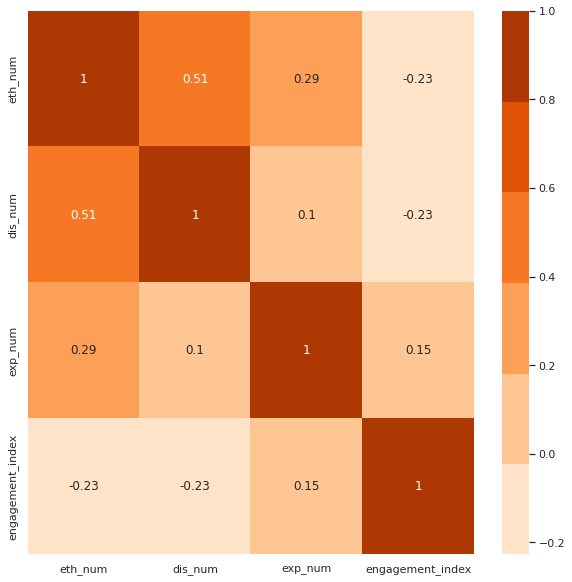

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(correlation_plot.corr(method='spearman'), annot=True, cmap=sns.color_palette('Oranges'))

We come up with 2 points from the above correlation heatmap: 
- Between `eth_num` and `dis_num`, as corr = -0.23, there is a weak monotically decreasing relationship between Ethnicity and Economic status variables
- Between `dis_num` and `exp_num`, as corr = 0.15, there is a weak monotically increasing relationship between Economic status and Expenditure variables

In conclusion, as there are monotically relationships between components of SES score, we can now segment the data per Demographic and Economy

### District segmentation by Product Function

In this section, we will apply KMeans to SES score in segmenting customers based on demographic and economic factors.

#### Career Planning and Job Search

First of all, we will calculate 3 components of SES score based on the Percent of days with higher engagement index between labels of one component. 

For example, with Ethnicity variable (`pct_black/hispnic`), we will rank The percent of days with higher engagement index based on 4 group of this variable: 
- 0-20%
- 20-40%
- 40-60%
- 60-80%

This will be resulted in a rank (or we will consider it as a score) for each group. 

We will do the same with other 2 variables (Economic status and Expenditure), then sum up all these 3 to get the final SES score for this product function (Career planning & Job search). Finally, we will apply KMeans to SES score to group districts into clusters and find out the characteristics of these clusters.

**Ranking Ethnicity variable (pct_black/hispanic)**

In [ ]:
df_cpjs = df[df['function'] == 'LC - Career Planning & Job Search'] 

In [ ]:
cpjs_eth = calculation_percent(df_cpjs, 'pct_black/hispanic', eth_value)
cpjs_eth

,pct_black/hispanic,percent_day_greater,score
0,"[0, 0.2[",9.289617,2.0
1,"[0.2, 0.4[",67.213115,4.0
2,"[0.4, 0.6[",0.273224,1.0
3,"[0.6, 0.8[",23.224044,3.0


In [ ]:
cpjs_eth_score = dict(cpjs_eth.iloc[:, [0,2]].values)
cpjs_eth_score

{'[0, 0.2[': 2.0, '[0.2, 0.4[': 4.0, '[0.4, 0.6[': 1.0, '[0.6, 0.8[': 3.0}

In [ ]:
df_cpjs['eth_score'] = df_cpjs['pct_black/hispanic'].map(cpjs_eth_score)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


**Ranking Economic status variable (pct_free/reduced)**

In [ ]:
cpjs_dis = calculation_percent(df_cpjs, 'pct_free/reduced', dis_value)
cpjs_dis

,pct_free/reduced,percent_day_greater,score
0,"[0, 0.2[",31.693989,3.0
1,"[0.2, 0.4[",57.103825,4.0
2,"[0.4, 0.6[",4.644809,1.0
3,"[0.6, 0.8[",6.557377,2.0


In [ ]:
cpjs_dis_score = dict(cpjs_dis.iloc[:, [0,2]].values)
cpjs_dis_score

{'[0, 0.2[': 3.0, '[0.2, 0.4[': 4.0, '[0.4, 0.6[': 1.0, '[0.6, 0.8[': 2.0}

In [ ]:
df_cpjs['dis_score'] = df_cpjs['pct_free/reduced'].map(cpjs_dis_score)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


**Ranking Expenditure variable (exp_group)**

In [ ]:
cpjs_exp = calculation_percent(df_cpjs, 'exp_group', exp_value)
cpjs_exp

,exp_group,percent_day_greater,score
0,4k-8k,0.000000,1.0
1,8k-12k,2.459016,2.0
2,12k-16k,3.005464,3.0
3,16k-20k,93.989071,4.0


In [ ]:
cpjs_exp_score = dict(cpjs_exp.iloc[:, [0,2]].values)
cpjs_exp_score

{'4k-8k': 1.0, '8k-12k': 2.0, '12k-16k': 3.0, '16k-20k': 4.0}

In [ ]:
df_cpjs['exp_score'] = df_cpjs['exp_group'].map(cpjs_exp_score)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


**Combine all to get SES score**

In [ ]:
df_cpjs['ses'] = df_cpjs['eth_score'] + df_cpjs['dis_score'] + df_cpjs['exp_score']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


**Applying KMeans to SES score to group districts into clusters**

In [ ]:
cpjs_district = df_cpjs.groupby('district_id')['ses'].mean().reset_index()
cpjs_district.head()

,district_id,ses
0,1044,7.0
1,1052,12.0
2,1204,6.0
3,1270,5.0
4,1324,5.0


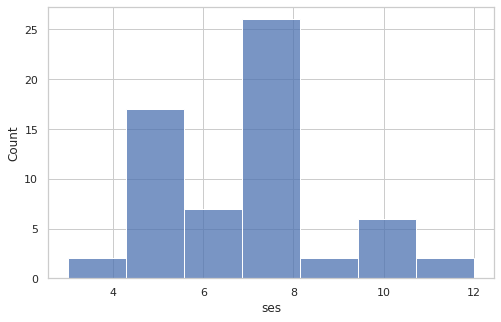

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(data=cpjs_district, x='ses')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (11). Possibly due to duplicate points in X.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (12). Possibly due to duplicate points in X.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (13). Possibly due to duplicate points in X.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/p

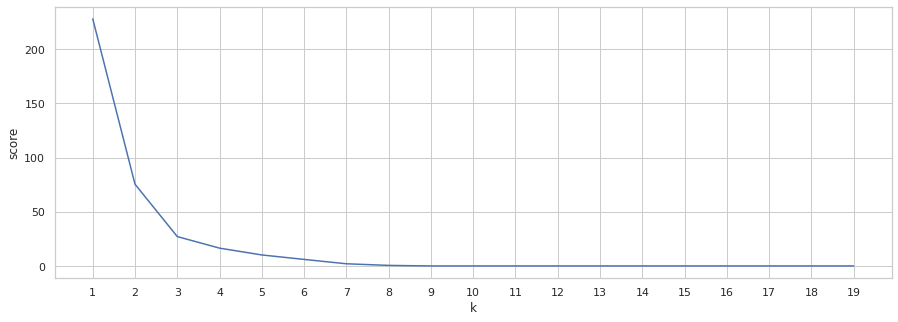

In [ ]:
from sklearn.cluster import KMeans

X = cpjs_district[['ses']].values

wcss = []
k_values = range(1,20)

for i in k_values:
  kmeans = KMeans(n_clusters = i, random_state = 42)
  kmeans.fit(X)
  wcss.append(kmeans.inertia_)

plt.figure(figsize=(15,5))
plt.plot(k_values, wcss)
plt.xlabel('k')
plt.xticks(range(1,20))
plt.ylabel('score')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X)
clusters = kmeans.predict(X)

In [ ]:
cpjs_district['cluster'] = clusters
cpjs_district

,district_id,ses,cluster
0,1044,7.0,1
1,1052,12.0,2
2,1204,6.0,0
3,1270,5.0,0
4,1324,5.0,0
...,...,...,...
57,9230,6.0,0
58,9553,8.0,1
59,9778,5.0,0
60,9812,7.0,1


In [ ]:
cpjs_district.groupby('cluster')['ses'].describe()

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0,26.0,5.153846,0.674822,3.0,5.0,5.0,5.75,6.0
1,28.0,7.714286,0.599824,7.0,7.0,8.0,8.00,9.0
2,8.0,10.500000,0.925820,10.0,10.0,10.0,10.50,12.0


**Insights and recommendations**

In [ ]:
df_cpjs = pd.merge(df_cpjs, cpjs_district[['district_id', 'cluster']], on='district_id', how='left')
df_cpjs.head(2)

,time,lp_id,pct_access,engagement_index,district_id,state,locale,pct_black/hispanic,pct_free/reduced,county_connections_ratio,...,name,provider,sector,function,exp_group,eth_score,dis_score,exp_score,ses,cluster
0,2020-01-17,41587,0.21,6.17,3710,Utah,Suburb,"[0, 0.2[","[0.4, 0.6[","[0.18, 1[",...,LinkedIn,LinkedIn,PreK-12; Higher Ed; Corporate,LC - Career Planning & Job Search,4k-8k,2.0,1.0,1.0,4.0,0
1,2020-02-18,41587,0.20,4.07,3710,Utah,Suburb,"[0, 0.2[","[0.4, 0.6[","[0.18, 1[",...,LinkedIn,LinkedIn,PreK-12; Higher Ed; Corporate,LC - Career Planning & Job Search,4k-8k,2.0,1.0,1.0,4.0,0


In [ ]:
df_cpjs['eth_num'] = df_cpjs['pct_black/hispanic'].map(eth_num)
df_cpjs['dis_num'] = df_cpjs['pct_free/reduced'].map(dis_num)
df_cpjs['exp_num'] = df_cpjs['exp_group'].map(exp_num)

In [ ]:
cpjs_dist_heat = df_cpjs.groupby(['cluster', 'district_id'])['eth_num', 'dis_num', 'exp_num'].mean().reset_index()
cpjs_dist_heat.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,cluster,district_id,eth_num,dis_num,exp_num
0,0,1204,0.1,0.1,6000.0
1,0,1270,0.1,0.5,10000.0
2,0,1324,0.1,0.5,10000.0
3,0,1536,0.1,0.5,10000.0
4,0,2130,0.5,0.7,14000.0


In [ ]:
cpjs_heat = cpjs_dist_heat.groupby('cluster').agg({'eth_num': 'mean',
                                                 'dis_num': 'mean',
                                                 'exp_num': 'mean', 
                                                 'district_id': 'count'}).reset_index()
cpjs_heat

,cluster,eth_num,dis_num,exp_num,district_id
0,0,0.207692,0.453846,9538.461538,26
1,1,0.214286,0.321429,10714.285714,28
2,2,0.275000,0.275000,13500.000000,8


In [ ]:
cpjs_heat['in_total'] = cpjs_heat['district_id'] / cpjs_dist_heat['district_id'].nunique()
cpjs_heat.head()

,cluster,eth_num,dis_num,exp_num,district_id,in_total
0,0,0.207692,0.453846,9538.461538,26,0.419355
1,1,0.214286,0.321429,10714.285714,28,0.451613
2,2,0.275000,0.275000,13500.000000,8,0.129032


In [ ]:
cpjs_heat = cpjs_heat.set_index('cluster')
cpjs_heat.iloc[:, [0,1,2,4]].T.style.background_gradient(cmap='RdBu', axis=1)

cluster,0,1,2
eth_num,0.207692,0.214286,0.275000
dis_num,0.453846,0.321429,0.275000
exp_num,9538.461538,10714.285714,13500.000000
in_total,0.419355,0.451613,0.129032


In [ ]:
cpjs_heat_plot = cpjs_heat.reset_index()
cpjs_heat_plot = cpjs_heat_plot.melt(id_vars=['cluster'], 
                                      value_vars=['eth_num', 'dis_num', 'exp_num', 'in_total'], 
                                      var_name='category', 
                                      value_name='value')
cpjs_heat_plot

,cluster,category,value
0,0,eth_num,0.207692
1,1,eth_num,0.214286
2,2,eth_num,0.275000
3,0,dis_num,0.453846
4,1,dis_num,0.321429
5,2,dis_num,0.275000
6,0,exp_num,9538.461538
7,1,exp_num,10714.285714
8,2,exp_num,13500.000000
9,0,in_total,0.419355


Characteristics of cluster 2:
- Smallest number of districts among clusters (13%), which means not many students are really care for their career
- Highest average Black/Hispanic rate but in general, the rate is still considered to be relatively low, which is considered as less multiracial districts
- Districts with relatively low percentage of students eligible for Free/Reduced price lunch (27.5%) are also belong to this cluster
- This cluster also has districts with highest expenditure

To be concluded, students in districts with low rate of Black/Hispanic communities and good economic conditions with great expenditure from government have more interests in planning for their future career and dream jobs.

In [ ]:
cpjs = df_cpjs[df_cpjs['cluster'] == 2].groupby(['cluster', 'state', 'district_id', 'pct_black/hispanic', 'pct_free/reduced', 'exp_group'])['ses'].mean().reset_index()
cpjs

,cluster,state,district_id,pct_black/hispanic,pct_free/reduced,exp_group,ses
0,2,Illinois,1052,"[0.2, 0.4[","[0.2, 0.4[",16k-20k,12.0
1,2,Illinois,4629,"[0, 0.2[","[0.2, 0.4[",16k-20k,10.0
2,2,Illinois,5890,"[0.2, 0.4[","[0.2, 0.4[",16k-20k,12.0
3,2,Illinois,9899,"[0.2, 0.4[","[0, 0.2[",12k-16k,10.0
4,2,North Carolina,7177,"[0.2, 0.4[","[0.2, 0.4[",8k-12k,10.0
5,2,Utah,4744,"[0.2, 0.4[","[0.2, 0.4[",8k-12k,10.0
6,2,Utah,7541,"[0.2, 0.4[","[0.2, 0.4[",8k-12k,10.0
7,2,Utah,7614,"[0.2, 0.4[","[0.2, 0.4[",8k-12k,10.0


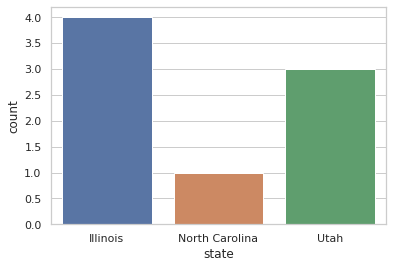

In [ ]:
sns.countplot(data=cpjs, x='state')

In this kind of product function, IIlinois is the state with highest number of districts (4) that have students paying attention to career planning and job search, followed by Utah with only 1 district difference.

In [ ]:
em_eth = pd.read_csv('/content/drive/MyDrive/Final Project/employment_all.csv')
em_eth

,ethnicity,em_total,em_percent,un_total,un_percent
0,All,"147,795",56.8,"12,947",8.1
1,White,"115,341",57.3,"9,090",7.3
2,Non-white,"21,913",56.2,"2,661",10.9


In [ ]:
un_rate = pd.read_csv('/content/drive/MyDrive/Final Project/unemployment_by_state_20yrs.csv')
un_rate.head()

,state,1999,1999.1,1999.2,1999.3,1999.4,1999.5,1999.6,1999.7,1999.8,...,2019.2,2019.3,2019.4,2019.5,2019.6,2019.7,2019.8,2019.9,2019.10,2019.11
0,LASST010000000000003,4.6,4.6,4.7,4.7,4.8,4.8,4.8,4.8,4.8,...,3.4,3.2,3.1,2.9,2.9,2.9,2.9,3.0,3.1,3.2
1,LASST020000000000003,6.5,6.5,6.5,6.6,6.5,6.5,6.4,6.4,6.3,...,5.6,5.5,5.5,5.5,5.5,5.5,5.4,5.3,5.2,5.2
2,LASST040000000000003,4.4,4.5,4.6,4.6,4.6,4.6,4.6,4.5,4.4,...,4.9,4.8,4.8,4.8,4.8,4.9,4.8,4.8,4.9,4.9
3,LASST050000000000003,4.7,4.6,4.6,4.5,4.5,4.6,4.6,4.5,4.5,...,3.4,3.4,3.4,3.4,3.4,3.5,3.5,3.5,3.5,3.5
4,LASST060000000000003,5.6,5.5,5.5,5.4,5.3,5.3,5.2,5.2,5.1,...,4.2,4.1,4.1,4.0,4.0,4.1,4.1,4.1,4.1,4.1


In [ ]:
un_rate_long = un_rate.melt(id_vars=['state'], 
                            value_vars=un_rate.columns[1:],
                            var_name='year',
                            value_name='unemployment_rate')

un_rate_long

,state,year,unemployment_rate
0,LASST010000000000003,1999,4.6
1,LASST020000000000003,1999,6.5
2,LASST040000000000003,1999,4.4
3,LASST050000000000003,1999,4.7
4,LASST060000000000003,1999,5.6
...,...,...,...
13099,LASST530000000000003,2019.11,3.9
13100,LASST540000000000003,2019.11,5.0
13101,LASST550000000000003,2019.11,3.2
13102,LASST560000000000003,2019.11,4.4


In [ ]:
un_rate_long['year'] = un_rate_long['year'].str[:4]

In [ ]:
un_rate_long['year'] = pd.to_datetime(un_rate_long['year'])

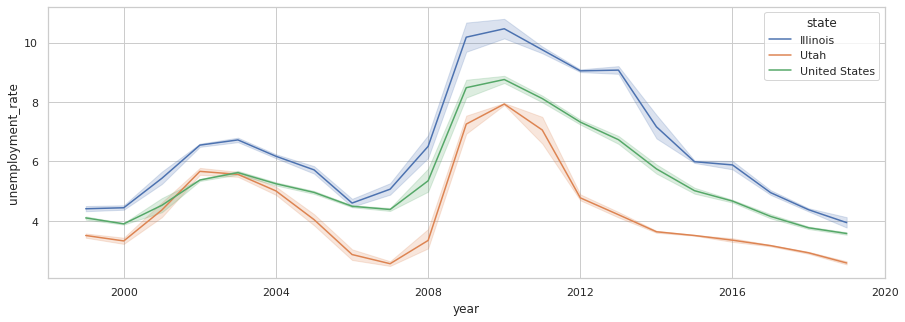

In [ ]:
plt.figure(figsize=(15,5))
sns.lineplot(data=un_rate_long[(un_rate_long['state'] == 'Utah') | (un_rate_long['state'] == 'Illinois') | (un_rate_long['state'] == 'United States')],
             x='year',
             y='unemployment_rate', 
             hue='state')

In order to understand the trending in employment in these 2 states, we will use Unemployment Rate dataset provided by U.S. Bureau of Labor Statistics over 50 states across U.S. <br>
In a period of 20 year from 1999 to 2019, both Illinois and Utah have overcome the strong fluctuation in unemployment rate, especially after the Early 2000s Recession and the Great Recession in 2008. Nevertheless, the unemployment rate in these 2 states have declined significantly till 2019 and they are almost asymptotic with the average line of the whole U.S, especially Utah with even lower unemployment rate most of the time. <br>
This can help to explain the above cluster result. As students pay more attention to their future career and look for the ways to land their dream jobs, which means they know what they want to become. Therefore, they can confidently enter the job market and the result would be in the low rate of unemployment at last.  


#### Information and Dictionary Resources

In [ ]:
df_tdr = df[df['function'] == 'LC - Sites, Resources & Reference'] 

In [ ]:
df_tdr['name'].unique()

array(['CNN Student News', 'Google Books', 'EngageNY', 'Google Earth',
       'PBS', 'CoolMath', 'Purdue Online Writing Lab', 'Mr. Donn',
       'Ptable', 'nytimes.com', 'Education.com', 'HowStuffWorks',
       'The Washington Post KidsPost', 'WWF ~ World Wildlife Fund',
       'Eventbrite', 'iCivics', 'Space.com', 'TedEd',
       'Library of Congress', 'Calculator.com', 'ReadWriteThink',
       'United States Holocaust Memorial Museum', 'SlideShare',
       'Interland', 'Earthquakes for Kids', 'Learn.Genetics', 'ABC News',
       'Live Science', 'Funbrain', 'StudyJams!', 'Vooks', 'Instructables',
       "NASA's Space Place", 'Storyline Online', 'ThoughtCo',
       'Mystery Science', 'Time', 'Learning for Justice',
       'Enchanted Learning', 'MarketWatch', 'Math is Fun',
       'online-stopwatch.com', 'History.com', 'Investopedia',
       'The Physics Classroom', 'remove.bg', 'Wakelet'], dtype=object)

**Ranking Ethnicity variable (pct_black/hispanic)**

In [ ]:
tdr_eth = calculation_percent(df_tdr, 'pct_black/hispanic', eth_value)
tdr_eth

,pct_black/hispanic,percent_day_greater,score
0,"[0, 0.2[",48.360656,4.0
1,"[0.2, 0.4[",42.349727,3.0
2,"[0.4, 0.6[",0.819672,1.0
3,"[0.6, 0.8[",8.469945,2.0


In [ ]:
tdr_eth_score = dict(tdr_eth.iloc[:, [0,2]].values)
tdr_eth_score

{'[0, 0.2[': 4.0, '[0.2, 0.4[': 3.0, '[0.4, 0.6[': 1.0, '[0.6, 0.8[': 2.0}

In [ ]:
df_tdr['eth_score'] = df_tdr['pct_black/hispanic'].map(tdr_eth_score)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


**Ranking Economic status variable (pct_free/reduced)**

In [ ]:
tdr_dis = calculation_percent(df_tdr, 'pct_free/reduced', dis_value)
tdr_dis

,pct_free/reduced,percent_day_greater,score
0,"[0, 0.2[",68.852459,4.0
1,"[0.2, 0.4[",11.748634,2.0
2,"[0.4, 0.6[",17.486339,3.0
3,"[0.6, 0.8[",1.912568,1.0


In [ ]:
tdr_dis_score = dict(tdr_dis.iloc[:, [0,2]].values)
tdr_dis_score

{'[0, 0.2[': 4.0, '[0.2, 0.4[': 2.0, '[0.4, 0.6[': 3.0, '[0.6, 0.8[': 1.0}

In [ ]:
df_tdr['dis_score'] = df_tdr['pct_free/reduced'].map(tdr_dis_score)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


**Ranking Expenditure variable (exp_group)**

In [ ]:
tdr_exp = calculation_percent(df_tdr, 'exp_group', exp_value)
tdr_exp

,exp_group,percent_day_greater,score
0,4k-8k,4.644809,1.0
1,8k-12k,11.748634,2.0
2,12k-16k,14.207650,3.0
3,16k-20k,69.398907,4.0


In [ ]:
tdr_exp_score = dict(tdr_exp.iloc[:, [0,2]].values)
tdr_exp_score

{'4k-8k': 1.0, '8k-12k': 2.0, '12k-16k': 3.0, '16k-20k': 4.0}

In [ ]:
df_tdr['exp_score'] = df_tdr['exp_group'].map(tdr_exp_score)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


**Combining all to get SES score**

In [ ]:
df_tdr['ses'] = df_tdr['eth_score'] + df_tdr['dis_score'] + df_tdr['exp_score']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


**Applying KMeans to SES score to group districts into clusters**

In [ ]:
tdr_district = df_tdr.groupby('district_id')['ses'].mean().reset_index()
tdr_district.head()

,district_id,ses
0,1044,10.0
1,1052,9.0
2,1204,9.0
3,1270,9.0
4,1324,9.0


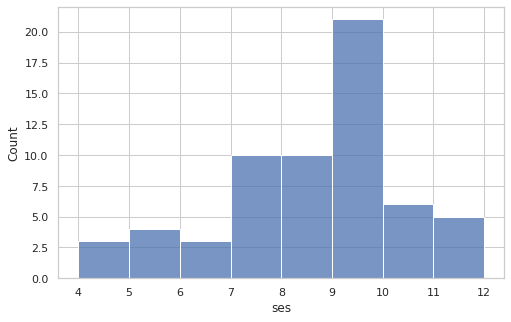

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(data=tdr_district, x='ses')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (11). Possibly due to duplicate points in X.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (12). Possibly due to duplicate points in X.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (13). Possibly due to duplicate points in X.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/p

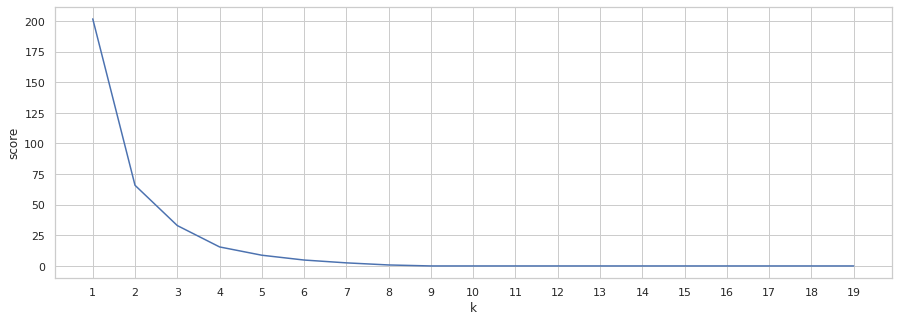

In [ ]:
from sklearn.cluster import KMeans

X = tdr_district[['ses']].values

wcss = []
k_values = range(1,20)

for i in k_values:
  kmeans = KMeans(n_clusters = i, random_state = 42)
  kmeans.fit(X)
  wcss.append(kmeans.inertia_)

plt.figure(figsize=(15,5))
plt.plot(k_values, wcss)
plt.xlabel('k')
plt.xticks(range(1,20))
plt.ylabel('score')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X)
clusters = kmeans.predict(X)

In [ ]:
tdr_district['cluster'] = clusters
tdr_district

,district_id,ses,cluster
0,1044,10.0,1
1,1052,9.0,1
2,1204,9.0,1
3,1270,9.0,1
4,1324,9.0,1
...,...,...,...
57,9230,9.0,1
58,9553,11.0,1
59,9778,9.0,1
60,9812,7.0,2


In [ ]:
tdr_district.groupby('cluster')['ses'].describe()

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0,10.0,5.00000,0.816497,4.0,4.25,5.0,5.75,6.0
1,32.0,9.53125,0.841825,9.0,9.00,9.0,10.00,12.0
2,20.0,7.50000,0.512989,7.0,7.00,7.5,8.00,8.0


In [ ]:
df_tdr = pd.merge(df_tdr, tdr_district[['district_id', 'cluster']], on='district_id', how='left')
df_tdr.head(2)

,time,lp_id,pct_access,engagement_index,district_id,state,locale,pct_black/hispanic,pct_free/reduced,county_connections_ratio,...,name,provider,sector,function,exp_group,eth_score,dis_score,exp_score,ses,cluster
0,2020-01-01,16633,0.21,2.07,3710,Utah,Suburb,"[0, 0.2[","[0.4, 0.6[","[0.18, 1[",...,CNN Student News,Cable News Network,PreK-12; Higher Ed; Corporate,"LC - Sites, Resources & Reference",4k-8k,4.0,3.0,1.0,8.0,2
1,2020-01-08,16633,0.21,2.06,3710,Utah,Suburb,"[0, 0.2[","[0.4, 0.6[","[0.18, 1[",...,CNN Student News,Cable News Network,PreK-12; Higher Ed; Corporate,"LC - Sites, Resources & Reference",4k-8k,4.0,3.0,1.0,8.0,2


**Insights and Recommendations**

In [ ]:
df_tdr['eth_num'] = df_tdr['pct_black/hispanic'].map(eth_num)
df_tdr['dis_num'] = df_tdr['pct_free/reduced'].map(dis_num)
df_tdr['exp_num'] = df_tdr['exp_group'].map(exp_num)

In [ ]:
tdr_dist_heat = df_tdr.groupby(['cluster', 'district_id'])['eth_num', 'dis_num', 'exp_num'].mean().reset_index()
tdr_dist_heat.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,cluster,district_id,eth_num,dis_num,exp_num
0,0,1791,0.7,0.7,10000.0
1,0,2130,0.5,0.7,14000.0
2,0,2165,0.3,0.3,6000.0
3,0,3222,0.3,0.7,10000.0
4,0,3248,0.7,0.7,14000.0


In [ ]:
tdr_heat = tdr_dist_heat.groupby('cluster').agg({'eth_num': 'mean',
                                                 'dis_num': 'mean',
                                                 'exp_num': 'mean', 
                                                 'district_id': 'count'}).reset_index()
tdr_heat

,cluster,eth_num,dis_num,exp_num,district_id
0,0,0.52000,0.64000,10000.0,10
1,1,0.13125,0.30625,11375.0,32
2,2,0.21000,0.34000,9600.0,20


In [ ]:
tdr_heat['in_total'] = tdr_heat['district_id'] / tdr_dist_heat['district_id'].nunique()
tdr_heat.head()

,cluster,eth_num,dis_num,exp_num,district_id,in_total
0,0,0.52000,0.64000,10000.0,10,0.161290
1,1,0.13125,0.30625,11375.0,32,0.516129
2,2,0.21000,0.34000,9600.0,20,0.322581


In [ ]:
tdr_heat = tdr_heat.set_index('cluster')
tdr_heat.iloc[:, [0,1,2,4]].T.style.background_gradient(cmap='RdBu', axis=1)

cluster,0,1,2
eth_num,0.520000,0.131250,0.210000
dis_num,0.640000,0.306250,0.340000
exp_num,10000.000000,11375.000000,9600.000000
in_total,0.161290,0.516129,0.322581


In [ ]:
tdr_heat_plot = tdr_heat.reset_index()
tdr_heat_plot = tdr_heat_plot.melt(id_vars=['cluster'], 
                                      value_vars=['eth_num', 'dis_num', 'exp_num', 'in_total'], 
                                      var_name='category', 
                                      value_name='value')
tdr_heat_plot

,cluster,category,value
0,0,eth_num,0.520000
1,1,eth_num,0.131250
2,2,eth_num,0.210000
3,0,dis_num,0.640000
4,1,dis_num,0.306250
5,2,dis_num,0.340000
6,0,exp_num,10000.000000
7,1,exp_num,11375.000000
8,2,exp_num,9600.000000
9,0,in_total,0.161290


Characteristics of districts in cluster 2:
- About 32% of districts having students that can self-study 
- In this cluster, districts have very low multiracial rate and students here also in families with favorable economic conditions
- Noticeably, government spending is lowest among the cluster groups

In conclusion, students in districts with mostly of white and high economic status with not much spending from government can perform self-studying well by actively looking for information they need

In [ ]:
tdr = df_tdr[df_tdr['cluster'] == 2].groupby(['cluster', 'state', 'district_id', 'pct_black/hispanic', 'pct_free/reduced', 'exp_group'])['ses'].mean().reset_index()
tdr

,cluster,state,district_id,pct_black/hispanic,pct_free/reduced,exp_group,ses
0,2,Illinois,2601,"[0.6, 0.8[","[0.4, 0.6[",12k-16k,8.0
1,2,Michigan,3732,"[0.4, 0.6[","[0.4, 0.6[",12k-16k,7.0
2,2,Missouri,1742,"[0, 0.2[","[0.2, 0.4[",8k-12k,8.0
3,2,Missouri,4051,"[0, 0.2[","[0.2, 0.4[",8k-12k,8.0
4,2,Missouri,4348,"[0, 0.2[","[0.2, 0.4[",8k-12k,8.0
5,2,Missouri,5422,"[0, 0.2[","[0.2, 0.4[",8k-12k,8.0
6,2,North Carolina,7177,"[0.2, 0.4[","[0.2, 0.4[",8k-12k,7.0
7,2,Utah,2441,"[0, 0.2[","[0.2, 0.4[",8k-12k,8.0
8,2,Utah,3160,"[0, 0.2[","[0.2, 0.4[",8k-12k,8.0
9,2,Utah,3710,"[0, 0.2[","[0.4, 0.6[",4k-8k,8.0


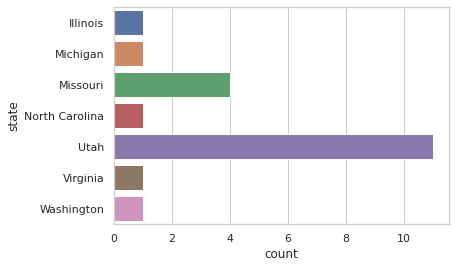

In [ ]:
sns.countplot(data=tdr, y='state')

Out of 7 states that have students with well self-studying, Utah has the highest number of districts with 11, followed by Missouri with 4. Each of remaining states has only 1 district.

We will then use the external dataset about SAT score in 2020 in U.S including the score, number of test takers and parental education background.

In [ ]:
sat = pd.read_csv('/content/drive/MyDrive/Final Project/sat_all.csv')
sat.head()

,category,detail,test_takers,sat,erw,math
0,ethnicity,Black/African American,271178,933,476,457
1,ethnicity,Hispanic/Latino,554665,978,495,483
2,ethnicity,White,947842,1114,562,553
3,parental,No High School Diploma,198564,926,464,462
4,parental,High School Diploma,608174,989,500,490


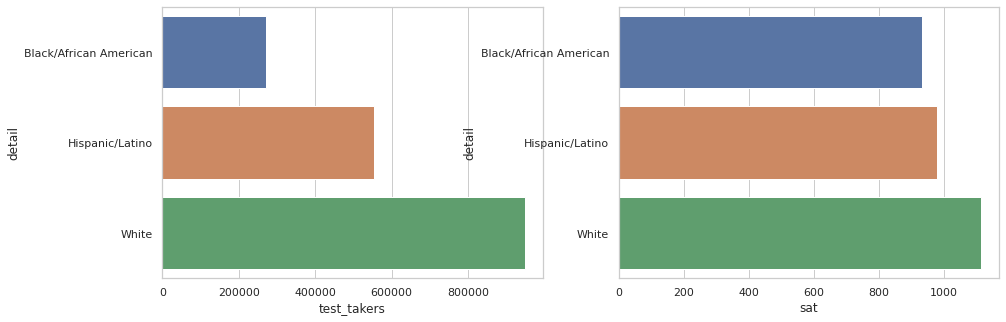

In [ ]:
plt.figure(figsize=(15,5))

plt.subplot(121)
sns.barplot(data=sat[sat['category'] == 'ethnicity'], 
            y='detail', 
            x='test_takers')

plt.subplot(122)
sns.barplot(data=sat[sat['category'] == 'ethnicity'], 
            y='detail', 
            x='sat')

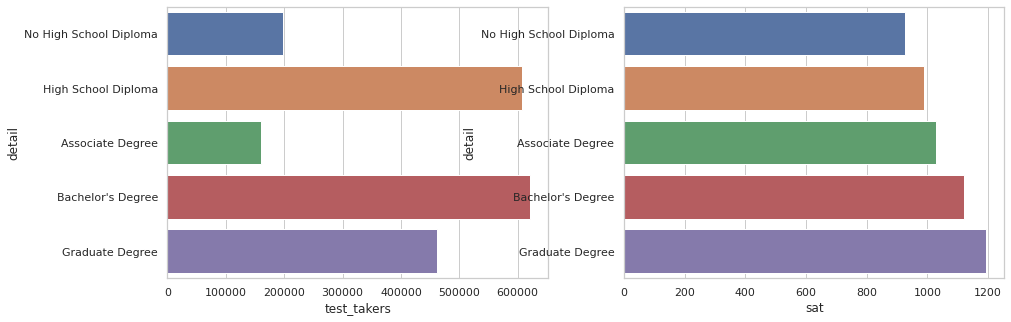

In [ ]:
plt.figure(figsize=(15,5))

plt.subplot(121)
sns.barplot(data=sat[sat['category'] == 'parental'], 
            y='detail', 
            x='test_takers')

plt.subplot(122)
sns.barplot(data=sat[sat['category'] == 'parental'], 
            y='detail', 
            x='sat')

Although the test takers could come from any parental education background, the highest average SAT score is still mostly achievable by students born in families with parents got an Associate Degree or above.

#### Content Creation & Curation

In [ ]:
df[df['function'] == 'LC - Content Creation & Curation']['name'].unique()

array(['MIT App Inventor', 'WeVideo for Schools', 'Google Docs',
       'Scratch', 'Vimeo', 'GitHub', 'Tinkercad', 'Autodesk', 'Prezi',
       'Jamboard', 'Microsoft XNA Game Studio', 'iStock', 'Pixlr',
       'Tes Teach', 'Adobe Character Animator', 'Adobe Spark', 'Wistia',
       'Google Drawings', 'Adobe Creative Cloud for Higher Ed',
       'Screencastify', 'ThingLink', 'Bitmoji', 'Flipgrid',
       'Screencast-O-Matic', 'Issuu', 'Book Creator', 'Padlet', 'Canva',
       'Seesaw : The Learning Journal', 'Canvas for Chrome',
       'SlidesCarnival', 'Soundtrap', 'Evite', 'CHROME MUSIC LAB',
       'Whiteboard.fi'], dtype=object)

In [ ]:
df_sdt = df[df['function'] == 'LC - Content Creation & Curation']

**Ranking Ethnicity variable (pct_black/hispanic)**

In [ ]:
sdt_eth = calculation_percent(df_sdt, 'pct_black/hispanic', eth_value)
sdt_eth

,pct_black/hispanic,percent_day_greater,score
0,"[0, 0.2[",21.038251,3.0
1,"[0.2, 0.4[",59.289617,4.0
2,"[0.4, 0.6[",0.000000,1.0
3,"[0.6, 0.8[",19.672131,2.0


In [ ]:
sdt_eth_score = dict(sdt_eth.iloc[:, [0,2]].values)
sdt_eth_score

{'[0, 0.2[': 3.0, '[0.2, 0.4[': 4.0, '[0.4, 0.6[': 1.0, '[0.6, 0.8[': 2.0}

In [ ]:
df_sdt['eth_score'] = df_sdt['pct_black/hispanic'].map(sdt_eth_score)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


**Ranking Economic status variable (pct_free/reduced)**

In [ ]:
sdt_dis = calculation_percent(df_sdt, 'pct_free/reduced', dis_value)
sdt_dis

,pct_free/reduced,percent_day_greater,score
0,"[0, 0.2[",82.513661,4.0
1,"[0.2, 0.4[",8.469945,3.0
2,"[0.4, 0.6[",6.010929,2.0
3,"[0.6, 0.8[",3.005464,1.0


In [ ]:
sdt_dis_score = dict(sdt_dis.iloc[:, [0,2]].values)
sdt_dis_score

{'[0, 0.2[': 4.0, '[0.2, 0.4[': 3.0, '[0.4, 0.6[': 2.0, '[0.6, 0.8[': 1.0}

In [ ]:
df_sdt['dis_score'] = df_sdt['pct_free/reduced'].map(sdt_dis_score)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


**Ranking Expenditure variable (exp_group)**

In [ ]:
sdt_exp = calculation_percent(df_sdt, 'exp_group', exp_value)
sdt_exp

,exp_group,percent_day_greater,score
0,4k-8k,0.000000,1.0
1,8k-12k,4.371585,2.0
2,12k-16k,7.377049,3.0
3,16k-20k,88.251366,4.0


In [ ]:
sdt_exp_score = dict(sdt_exp.iloc[:, [0,2]].values)
sdt_exp_score

{'4k-8k': 1.0, '8k-12k': 2.0, '12k-16k': 3.0, '16k-20k': 4.0}

In [ ]:
df_sdt['exp_score'] = df_sdt['exp_group'].map(sdt_exp_score)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


**Combining all to get SES score**

In [ ]:
df_sdt['ses'] = df_sdt['eth_score'] + df_sdt['dis_score'] + df_sdt['exp_score']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


**Applying KMeans to SES score to group districts into clusters**

In [ ]:
sdt_district = df_sdt.groupby('district_id')['ses'].mean().reset_index()
sdt_district.head()

,district_id,ses
0,1044,9.0
1,1052,11.0
2,1204,8.0
3,1270,7.0
4,1324,7.0


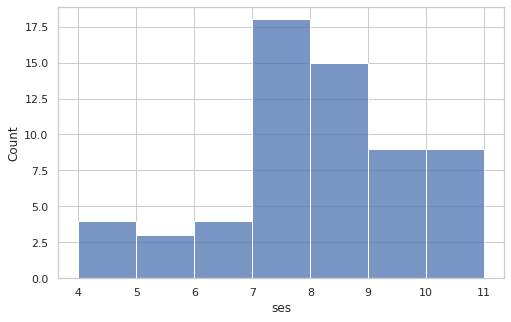

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(data=sdt_district, x='ses')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (11). Possibly due to duplicate points in X.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (12). Possibly due to duplicate points in X.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/py

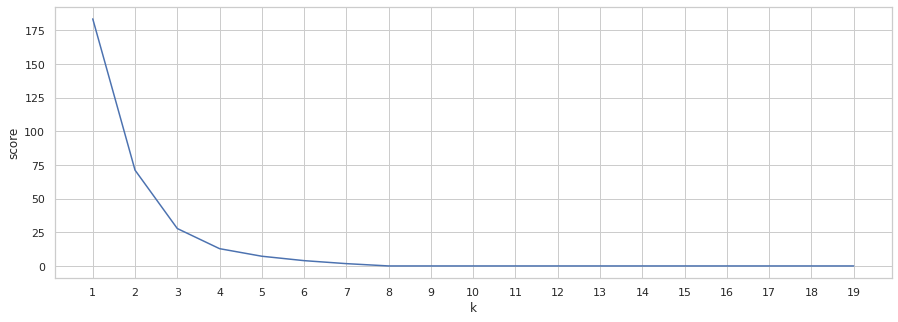

In [ ]:
from sklearn.cluster import KMeans

X = sdt_district[['ses']].values

wcss = []
k_values = range(1,20)

for i in k_values:
  kmeans = KMeans(n_clusters = i, random_state = 40)
  kmeans.fit(X)
  wcss.append(kmeans.inertia_)

plt.figure(figsize=(15,5))
plt.plot(k_values, wcss)
plt.xlabel('k')
plt.xticks(range(1,20))
plt.ylabel('score')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X)
clusters = kmeans.predict(X)

In [ ]:
sdt_district['cluster'] = clusters
sdt_district

,district_id,ses,cluster
0,1044,9.0,0
1,1052,11.0,0
2,1204,8.0,1
3,1270,7.0,1
4,1324,7.0,1
...,...,...,...
57,9230,8.0,1
58,9553,10.0,0
59,9778,7.0,1
60,9812,7.0,1


In [ ]:
sdt_district.groupby('cluster')['ses'].describe()

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0,18.0,9.722222,0.826442,9.0,9.0,9.5,10.0,11.0
1,37.0,7.297297,0.661012,6.0,7.0,7.0,8.0,8.0
2,7.0,4.428571,0.534522,4.0,4.0,4.0,5.0,5.0


In [ ]:
df_sdt = pd.merge(df_sdt, sdt_district[['district_id', 'cluster']], on='district_id', how='left')
df_sdt.head(2)

,time,lp_id,pct_access,engagement_index,district_id,state,locale,pct_black/hispanic,pct_free/reduced,county_connections_ratio,...,name,provider,sector,function,exp_group,eth_score,dis_score,exp_score,ses,cluster
0,2020-01-01,15254,0.21,2.07,3710,Utah,Suburb,"[0, 0.2[","[0.4, 0.6[","[0.18, 1[",...,MIT App Inventor,Massachusetts Institute of Technology,PreK-12; Higher Ed; Corporate,LC - Content Creation & Curation,4k-8k,3.0,2.0,1.0,6.0,1
1,2020-01-04,15254,0.41,20.66,3710,Utah,Suburb,"[0, 0.2[","[0.4, 0.6[","[0.18, 1[",...,MIT App Inventor,Massachusetts Institute of Technology,PreK-12; Higher Ed; Corporate,LC - Content Creation & Curation,4k-8k,3.0,2.0,1.0,6.0,1


**Insights and Recommendations**

In [ ]:
df_sdt['eth_num'] = df_sdt['pct_black/hispanic'].map(eth_num)
df_sdt['dis_num'] = df_sdt['pct_free/reduced'].map(dis_num)
df_sdt['exp_num'] = df_sdt['exp_group'].map(exp_num)

In [ ]:
sdt_dist_heat = df_sdt.groupby(['cluster', 'district_id'])['eth_num', 'dis_num', 'exp_num', 'engagement_index'].mean().reset_index()
sdt_dist_heat.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,cluster,district_id,eth_num,dis_num,exp_num,engagement_index
0,0,1044,0.1,0.1,10000.0,694.770538
1,0,1052,0.3,0.3,18000.0,860.535032
2,0,1705,0.3,0.5,14000.0,552.951163
3,0,2393,0.1,0.1,14000.0,1162.789254
4,0,2779,0.1,0.1,10000.0,1913.311125


In [ ]:
sdt_heat = sdt_dist_heat.groupby('cluster').agg({'eth_num': 'mean',
                                                 'dis_num': 'mean',
                                                 'exp_num': 'mean', 
                                                 'district_id': 'count'}).reset_index()
sdt_heat

,cluster,eth_num,dis_num,exp_num,district_id
0,0,0.200000,0.222222,13333.333333,18
1,1,0.164865,0.386486,9351.351351,37
2,2,0.557143,0.671429,10000.000000,7


In [ ]:
sdt_heat['in_total'] = sdt_heat['district_id'] / sdt_dist_heat['district_id'].nunique()
sdt_heat.head()

,cluster,eth_num,dis_num,exp_num,district_id,in_total
0,0,0.200000,0.222222,13333.333333,18,0.290323
1,1,0.164865,0.386486,9351.351351,37,0.596774
2,2,0.557143,0.671429,10000.000000,7,0.112903


In [ ]:
sdt_heat = sdt_heat.set_index('cluster')
sdt_heat.iloc[:, [0,1,2,4]].T.style.background_gradient(cmap='RdBu', axis=1)

cluster,0,1,2
eth_num,0.200000,0.164865,0.557143
dis_num,0.222222,0.386486,0.671429
exp_num,13333.333333,9351.351351,10000.000000
in_total,0.290323,0.596774,0.112903


In [ ]:
sdt_heat_plot = sdt_heat.reset_index()
sdt_heat_plot = sdt_heat_plot.melt(id_vars=['cluster'], 
                                      value_vars=['eth_num', 'dis_num', 'exp_num', 'in_total'], 
                                      var_name='category', 
                                      value_name='value')
sdt_heat_plot

,cluster,category,value
0,0,eth_num,0.200000
1,1,eth_num,0.164865
2,2,eth_num,0.557143
3,0,dis_num,0.222222
4,1,dis_num,0.386486
5,2,dis_num,0.671429
6,0,exp_num,13333.333333
7,1,exp_num,9351.351351
8,2,exp_num,10000.000000
9,0,in_total,0.290323


Characteristics of cluster 2: 
- Smallest number of districts among clusters (11%), which means not many students are really interested in this product function
- Surprisingly, students of color in unfavorable economic conditions tend to have attention on Content Creation
- Districts where these students are in have a medium amount of budget spending on education. 

In conclusion, students in districts with high multiracial rate and not good economic status expose their interests in content creation and curation the best while district governments also spend an average amount of budget on their local education

In [ ]:
sdt = df_sdt[df_sdt['cluster'] == 2].groupby(['cluster', 'state', 'district_id', 'pct_black/hispanic', 'pct_free/reduced', 'exp_group'])['ses'].mean().reset_index()
sdt

,cluster,state,district_id,pct_black/hispanic,pct_free/reduced,exp_group,ses
0,2,Florida,6919,"[0.4, 0.6[","[0.4, 0.6[",4k-8k,4.0
1,2,Illinois,8784,"[0.6, 0.8[","[0.6, 0.8[",8k-12k,5.0
2,2,Michigan,6144,"[0.4, 0.6[","[0.6, 0.8[",8k-12k,4.0
3,2,North Carolina,6584,"[0.4, 0.6[","[0.6, 0.8[",8k-12k,4.0
4,2,North Carolina,7767,"[0.4, 0.6[","[0.6, 0.8[",8k-12k,4.0
5,2,Virginia,1791,"[0.6, 0.8[","[0.6, 0.8[",8k-12k,5.0
6,2,Washington,2130,"[0.4, 0.6[","[0.6, 0.8[",12k-16k,5.0


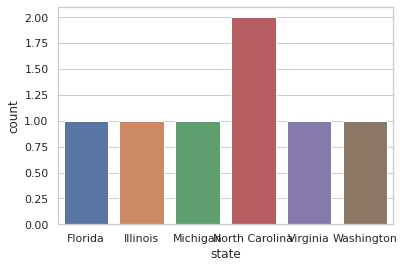

In [ ]:
sns.countplot(data=sdt, x='state')

Out of 6 states, North Carolina has 2 districts that have students interested in content creation and curation while others have 1 each. 

In [ ]:
content = pd.read_csv('/content/drive/MyDrive/Final Project/content_creator_by_ethnicity.csv')
content.head()

,year,white,black/african,asian,hispanic/latino
0,2010,74.27%,5.20%,8.57%,8.22%
1,2011,73.17%,4.96%,9.00%,9.66%
2,2012,72.93%,6.22%,8.43%,9.12%
3,2013,73.35%,6.77%,8.03%,8.73%
4,2014,72.75%,6.36%,8.46%,9.35%


In [ ]:
content['white'] = content['white'].str.rstrip('%')
content['black/african'] = content['black/african'].str.rstrip('%')
content['asian'] = content['asian'].str.rstrip('%')
content['hispanic/latino'] = content['hispanic/latino'].str.rstrip('%')
content.head()

,year,white,black/african,asian,hispanic/latino
0,2010,74.27,5.20,8.57,8.22
1,2011,73.17,4.96,9.00,9.66
2,2012,72.93,6.22,8.43,9.12
3,2013,73.35,6.77,8.03,8.73
4,2014,72.75,6.36,8.46,9.35


In [ ]:
content['white'] = content['white'].astype('float')
content['black/african'] = content['black/african'].astype('float')
content['asian'] = content['asian'].astype('float')
content['hispanic/latino'] = content['hispanic/latino'].astype('float')

In [ ]:
content['non_white'] = content['black/african'] + content['hispanic/latino'] + content['asian']
content.head()

,year,white,black/african,asian,hispanic/latino,non_white
0,2010,74.27,5.20,8.57,8.22,21.99
1,2011,73.17,4.96,9.00,9.66,23.62
2,2012,72.93,6.22,8.43,9.12,23.77
3,2013,73.35,6.77,8.03,8.73,23.53
4,2014,72.75,6.36,8.46,9.35,24.17


In [ ]:
content_long = content[['year', 'white', 'non_white']].melt(id_vars=['year'], 
                            value_vars=['white', 'non_white'],
                            var_name='ethnicity',
                            value_name='percent')

content_long.head()

,year,ethnicity,percent
0,2010,white,74.27
1,2011,white,73.17
2,2012,white,72.93
3,2013,white,73.35
4,2014,white,72.75


In [ ]:
content_long['year'] = content_long['year'].astype('str')
content_long['year'] = pd.to_datetime(content_long['year'])

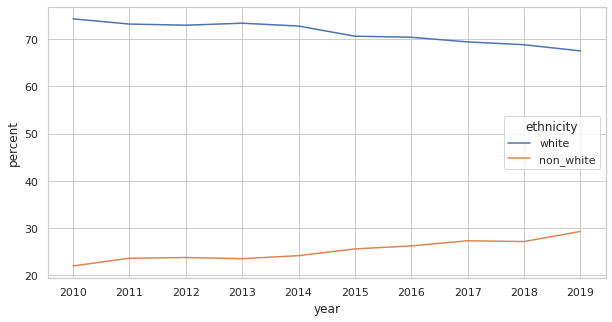

In [ ]:
plt.figure(figsize=(10,5))
sns.lineplot(data=content_long, 
             x='year', 
             y='percent', 
             hue='ethnicity')

We continuously use a dataset which describes the percentage of each ethnic category trended between 2010-2019 among content creators provided by U.S Census Bureau. <br>
Based on this dataset, more and more content creators are coming from colors communities expressed by 2 lines that gradually increases over the time. We also see the decrease in percentage of content creator of white in this period despite of the fact that they are still the largest group among ethnic categories in U.S <br>
From the cluster result, the characteristics of cluster 2 already reflected this kind of trend as more color students express their interests in content creation area. 

## Conclusion

Based on the above results, we can come up with final conclusions:
- Regarding **Career Planning & Job Search** product, we will focus mostly on white students with high economic condition of family as well as great expenditure spending of government
- Regarding **Information & Dictionary Resources** product, students living in not too much diversed society and low expenditure spending will be our target customers. And they might come from a medium economic background family. 
- Regarding **Content Creation & Curation** product, the customer target here is way more different from the above 2 products. Students living in districts with high multiracial rate and not good economic status express their interests in this type of product. And the district goverments here also spend an average amount of budget on their local education only. This user persona can be guaranteed by the trend of more and more content creators coming from colors communities

# Final words

Thank you for spending your precious time in reading my above project. Please kindly see my presentation slide with visualization in Tableau in following link: <br>
https://drive.google.com/file/d/1cPFMV3HJhfp-hlZYWLofisE6HEPLiHCN/view?usp=sharing